## Hold-up tank Model

Using fmdtools to simulate hazards in a system with human-component interactions, including:

- human-induced failure modes
- human responses to component failure modes
- joint human-component failure modes

The system to model is in `tank_model.py`

In [1]:
import sys
paths = sys.path
if paths[1]!='../':
    sys.path=[sys.path[0]] + ['../'] + paths

import fmdtools.faultsim.propagate as propagate
import fmdtools.resultdisp as rd
from tank_model import Tank
from fmdtools.modeldef import SampleApproach

### Verifying the nominal state:

In the nominal state, no change in system state should occur and the tank level should remain at 5.

In [2]:
mdl = Tank()
endresults, resgraph, mdlhist = propagate.nominal(mdl)

In [3]:
mdlhist.keys()

dict_keys(['flows', 'functions', 'time'])

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x26da03d1908>)

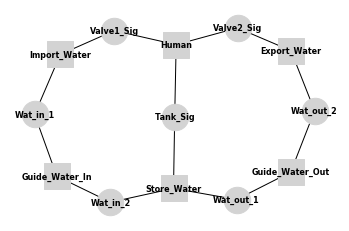

In [4]:
rd.graph.show(resgraph)

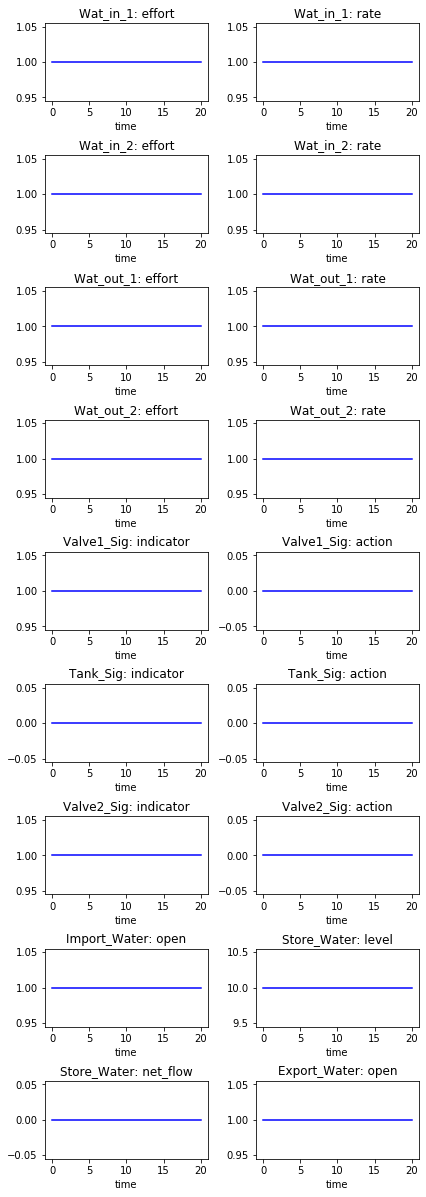

In [5]:
rd.plot.mdlhistvals(mdlhist)

### What happens under component faults?


Here we model a leak of the tank. To compensate for this leak, the operator opens the first valve to a higher setting, maintaining the level of the tank

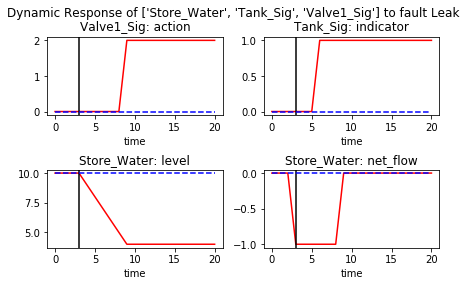

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x26da2d3ea88>)

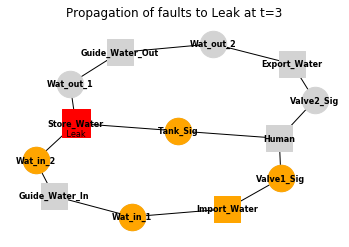

In [6]:
endresults, resgraph, mdlhist = propagate.one_fault(mdl,'Store_Water','Leak', time=3)

rd.plot.mdlhistvals(mdlhist, fault='Leak', time=3, fxnflowvals={'Store_Water':['level', 'net_flow'], 'Tank_Sig':['indicator'], 'Valve1_Sig':['action']}, legend=False)
rd.graph.show(resgraph,faultscen='Leak', time=3)


### What about human-induced faults?

Here we evaluate what happens if the operator thinks they see a low or high indicator and takes those given actions.

Note that in these cases, because of the indicator/procedures, the operators are able to correct for the fault.

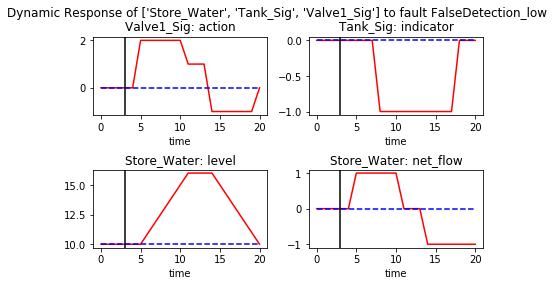

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x26da2c32548>)

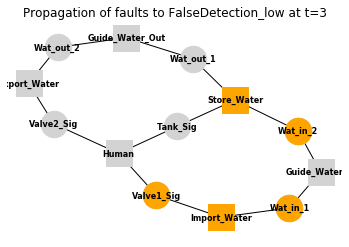

In [7]:
endresults, resgraph, mdlhist = propagate.one_fault(mdl,'Human','FalseDetection_low', time=3)

rd.plot.mdlhistvals(mdlhist, fault='FalseDetection_low', time=3, fxnflowvals={'Store_Water':['level', 'net_flow'], 'Tank_Sig':['indicator'], 'Valve1_Sig':['action']}, legend=False)
rd.graph.show(resgraph,faultscen='FalseDetection_low', time=3)

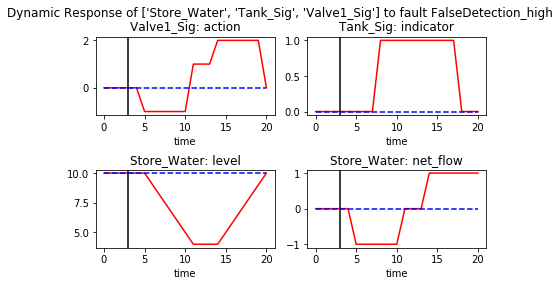

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x26da26413c8>)

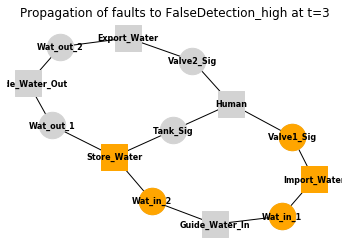

In [8]:
endresults, resgraph, mdlhist = propagate.one_fault(mdl,'Human','FalseDetection_high', time=3)

rd.plot.mdlhistvals(mdlhist, fault='FalseDetection_high', time=3, fxnflowvals={'Store_Water':['level', 'net_flow'], 'Tank_Sig':['indicator'], 'Valve1_Sig':['action']}, legend=False)
rd.graph.show(resgraph,faultscen='FalseDetection_high', time=3)

### Evaluating Joint Component-Human fault modes 

To understand where the risks of failure are, we need to find the scenarios, that, with the modelled human controls, still lead to failures. To assess this, we develop a sample approach.

In [9]:
#app_full = SampleApproach(mdl)
#endclasses, mdlhists = fp.run_approach(mdl, app_full)

Here we consider all single and joint-fault scenarios in the set of simulations to see which ones lead to failure:

In [10]:
app_joint_faults = SampleApproach(mdl, faults='all', jointfaults={'faults': 2})
endclasses, mdlhists = propagate.approach(mdl, app_joint_faults)
fmea_tab = rd.tabulate.simplefmea(endclasses)
fmea_tab

..\fmdtools\modeldef.py:1219: RuntimeWarning: invalid value encountered in double_scalars
  self.rates_timeless[jointmode][phaseid] = self.rates[jointmode][phaseid]/(overlap[1]-overlap[0])
SCENARIOS COMPLETE: 100%|█████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 411.17it/s]


,rate,cost,expected cost
"Import_Water Stuck, t=0",1.666667e-06,0.0,0.000000
"Guide_Water_In Leak, t=0",1.666667e-06,0.0,0.000000
"Guide_Water_In Clogged, t=0",1.666667e-06,1000000.0,166666.666667
"Store_Water Leak, t=0",1.666667e-06,0.0,0.000000
"Guide_Water_Out Leak, t=0",1.666667e-06,1000000.0,166666.666667
...,...,...,...
"Export_Water: Stuck, Human: CannotTurn, t=0",4.034949e-07,0.0,0.000000
"Export_Water: Stuck, Human: FalseDetection_low, t=0",1.388878e-11,0.0,0.000000
"Export_Water: Stuck, Human: FalseDetection_high, t=0",1.388878e-11,0.0,0.000000
"Human FalseDetection_low, t=10",1.583333e-04,0.0,0.000000


Next, we can filter out non-failures and sort by the failures with the highest expected cost (though rate would give the same results here)

In [11]:
failure_tab = fmea_tab[fmea_tab['cost'] > 1]
failure_tab.sort_values('expected cost', ascending = False)

,rate,cost,expected cost
"Guide_Water_In Clogged, t=0",1.666667e-06,1000000.0,166666.666667
"Guide_Water_Out Leak, t=0",1.666667e-06,1000000.0,166666.666667
"Guide_Water_In: Leak, Human: CannotTurn, t=0",4.034949e-07,1000000.0,40349.490951
"Guide_Water_Out: Clogged, Human: CannotTurn, t=0",4.034949e-07,1000000.0,40349.490951
"Store_Water: Leak, Human: CannotTurn, t=0",4.034949e-07,1000000.0,40349.490951
"Guide_Water_In: Clogged, Human: CannotTurn, t=0",4.034949e-07,1000000.0,40349.490951
"Guide_Water_Out: Leak, Human: CannotTurn, t=0",4.034949e-07,1000000.0,40349.490951
"Store_Water: Leak, Human: NotDetected, t=0",3.444339e-07,1000000.0,34443.390210
"Guide_Water_In: Clogged, Human: NotDetected, t=0",3.444339e-07,1000000.0,34443.390210
"Guide_Water_Out: Leak, Human: NotDetected, t=0",3.444339e-07,1000000.0,34443.390210


One of the top modes is a joint human-component failure mode. Let's see what happens in this case:

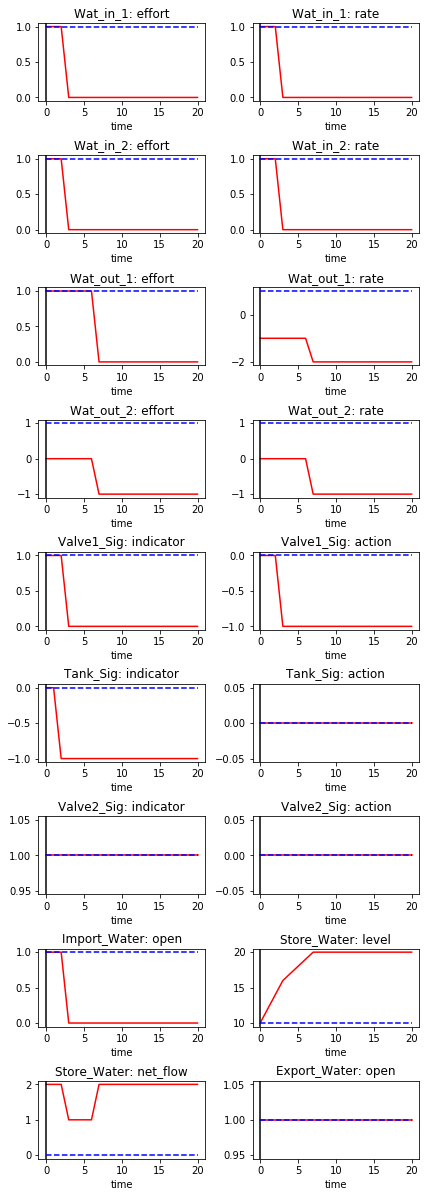

In [12]:
scenhists ={'nominal':mdlhists['nominal'], 'faulty':mdlhists['Guide_Water_Out: Leak, Human: FalseDetection_high, t=0']}
rd.plot.mdlhistvals(scenhists)

In this case, there is a leak, but the operator cannot turn the valve, resulting in the tank filling too high, which is a failure.

To consider the leak again, we can see what happens when the leak is not detected:

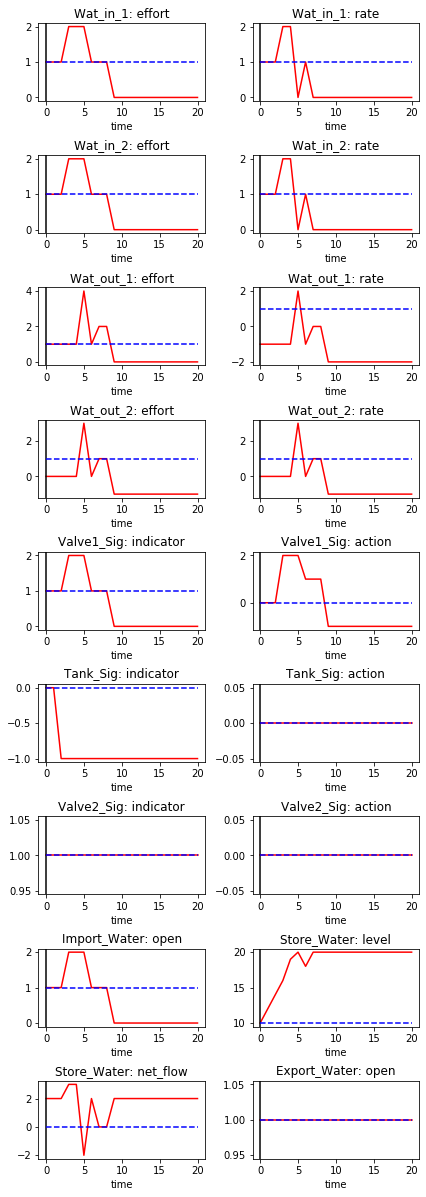

In [13]:
scenhists ={'nominal':mdlhists['nominal'], 'faulty':mdlhists['Guide_Water_Out: Leak, Human: FalseDetection_low, t=0']}
rd.plot.mdlhistvals(scenhists)

In this case, there is a leak, but it is not caugh, resulting in a failure again.

### Testing different reaction times

The model set up in `tank_model` is parameterized by the reaction time of the operator. As a result, we can assess how long or short reaction times affect the given scenarios.

In [14]:
mdl_long_reaction_time = Tank(params={'reacttime':10})

In this case, we will show the affect of reaction time on the operator's ability to catch a leak.

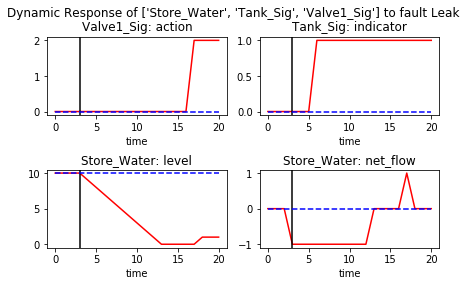

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x26da2a5c048>)

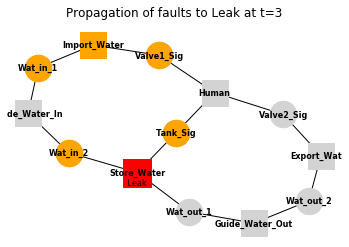

In [15]:
endresults, resgraph, mdlhist = propagate.one_fault(mdl_long_reaction_time,'Store_Water','Leak', time=3)

rd.plot.mdlhistvals(mdlhist, fault='Leak', time=3, fxnflowvals={'Store_Water':['level', 'net_flow'], 'Tank_Sig':['indicator'], 'Valve1_Sig':['action']}, legend=False)
rd.graph.show(resgraph,faultscen='Leak', time=3)


As shown, the operator does not respond in time, resulting in the tank draining all the way, a failure state. We can further use the `propagate.approach` function to compare the number of scenarios caught in this system compared with the other.